# Feature engineering
### Stellar Classification Dataset - SDSS17
https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS\
alpha = Right Ascension angle (at J2000 epoch)\
delta = Declination angle (at J2000 epoch)\
u = Ultraviolet filter in the photometric system\
g = Green filter in the photometric system\
r = Red filter in the photometric system\
i = Near Infrared filter in the photometric system\
z = Infrared filter in the photometric system\
run_ID = Run Number used to identify the specific scan\
rereun_ID = Rerun Number to specify how the image was processed\
cam_col = Camera column to identify the scanline within the run\
field_ID = Field number to identify each field\
spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)\
class = object class (galaxy, star or quasar object)\
redshift = redshift value based on the increase in wavelength\
plate = plate ID, identifies each plate in SDSS\
MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken\
fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation\

#### Citation
fedesoriano. (January 2022). Stellar Classification Dataset - SDSS17. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17.

Acknowledgements
The data released by the SDSS is under public domain. Its taken from the current data release RD17.

More information about the license: http://www.sdss.org/science/image-gallery/

### Wczytanie potrzebnych elementów i wstępna obróbka danych

Wczytanie bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import sklearn 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

Wczytanie i korekta ramki danych

In [2]:
# Wczytanie danych
df_original = pd.read_csv(".\\dane\\star_classification.csv")
development_unit_df, test_sample_df = train_test_split(df_original, test_size=0.3, random_state=42)

# Usuwanie kolumn, które są skorelowane z innymi ze współczynnikiem 1
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'rerun_ID']
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'obj_ID']
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'plate']
# Usuwanie błędnej obserwacji
development_unit_df = development_unit_df[development_unit_df['u'] > 0]

development_unit_df.head()

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,MJD,fiber_ID
76513,130.932167,4.313411,20.13070,18.37146,17.49792,17.06977,16.77949,3015,3,112,1.337614e+18,GALAXY,0.155863,52650,165
60406,225.429599,33.172083,19.86315,18.93886,18.59344,18.46922,18.40977,3900,5,594,3.304619e+18,STAR,-0.000529,54652,374
27322,219.173525,55.511740,19.84785,17.60157,16.71511,16.41555,16.25413,3225,4,74,3.711097e+18,STAR,-0.000261,54909,475
53699,178.735461,36.044139,17.83635,16.47576,15.82407,15.45751,15.18434,4552,6,67,2.367855e+18,GALAXY,0.068444,53467,317
65412,192.807458,18.727770,24.27039,22.60266,20.47710,19.45898,19.08250,5314,1,105,6.596788e+18,GALAXY,0.540778,56065,510


### Używane funkcje

In [3]:
def standard_distribution_info(variable_name):
    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    sns.histplot(data=df, x=variable_name, color='#17becf', ax=ax[0]).set(title='All classes')
    sns.histplot(data=df[df['class']=='GALAXY'], x=variable_name, color='#1f77b4', ax=ax[1]).set(title='GALAXY')
    sns.histplot(data=df[df['class']=='QSO'], x=variable_name, color='#ff7f0e', ax=ax[2]).set(title='QSO')
    sns.histplot(data=df[df['class']=='STAR'], x=variable_name, color='#2ca02c', ax=ax[3]).set(title='STAR')
    fig.tight_layout(pad=5.0)
    fig.show()

def standard_boxplot_info(variable_namem, show_text):
    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    sns.boxplot(data=df, x=variable_name, color='#17becf', ax=ax[0]).set(title='All classes')
    sns.boxplot(data=df[df['class']=='GALAXY'], x=variable_name, color='#1f77b4', ax=ax[1]).set(title='GALAXY')
    sns.boxplot(data=df[df['class']=='QSO'], x=variable_name, color='#ff7f0e', ax=ax[2]).set(title='QSO')
    sns.boxplot(data=df[df['class']=='STAR'], x=variable_name, color='#2ca02c', ax=ax[3]).set(title='STAR')
    fig.tight_layout(pad=5.0)
    fig.show()
    if (show_text):
        boxplot_info(variable_name)
    
def boxplot_info(variable_name):
    # outliery są znajdywane za pomocą metody 1.5IQR
    print('All classes:')
    selected_df = df[variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('GALAXY:')
    selected_df = df[df['class']=='GALAXY'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('QSO:')
    selected_df = df[df['class']=='QSO'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('STAR:')
    selected_df = df[df['class']=='STAR'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    
def standard_correlation_visualisation(variable_name, limit, show_text):
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[:5], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[5:10], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[10:15], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[15:18], hue='class')
    plt.show()
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    df_correlation[variable_name].plot.bar(color='#17becf', ylim=(-1, 1), ax=ax[0, 0]).set(title='All classes correlations') 
    df_correlation_GALAXY[variable_name].plot.bar(color='#1f77b4', ylim=(-1, 1), ax=ax[0, 1]).set(title='GALAXY correlations')
    df_correlation_QSO[variable_name].plot.bar(color='#ff7f0e', ylim=(-1, 1), ax=ax[1, 0]).set(title='QSO correlations')
    df_correlation_STAR[variable_name].plot.bar(color='#2ca02c', ylim=(-1, 1), ax=ax[1, 1]).set(title='STAR correlations')
    ax[0, 0].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-')
    ax[0, 1].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-') 
    ax[1, 0].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-')
    ax[1, 1].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-') 
    fig.tight_layout(pad=5.0)
    fig.show()
    if (show_text):
        print('korelacja:')
        print('all_classes: \n%s' %df_correlation.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('GALAXY: \n%s' %df_correlation_GALAXY.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('QSO: \n%s' %df_correlation_QSO.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('STAR: \n%s' %df_correlation_STAR.sort_values(by=[variable_name], ascending=False)[variable_name])
        
def test_models(df):
    # Podział na dane do trenowania i dane do walidacji
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('class', axis=1), df['class'], test_size=0.2, random_state=42)

    print('Dokładności modeli:')
    
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("LogisticRegression", accuracy)
    
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("KNeighborsClassifier:", accuracy)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("RandomForestClassifier:", accuracy)
    
    model = DecisionTreeClassifier(random_state=42)  # Ustawiamy random_state dla powtarzalności wyników
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("DecisionTreeClassifier:", accuracy)


# Inżynieria cech

### Pierwsza iteracja

In [4]:
df = development_unit_df.copy()

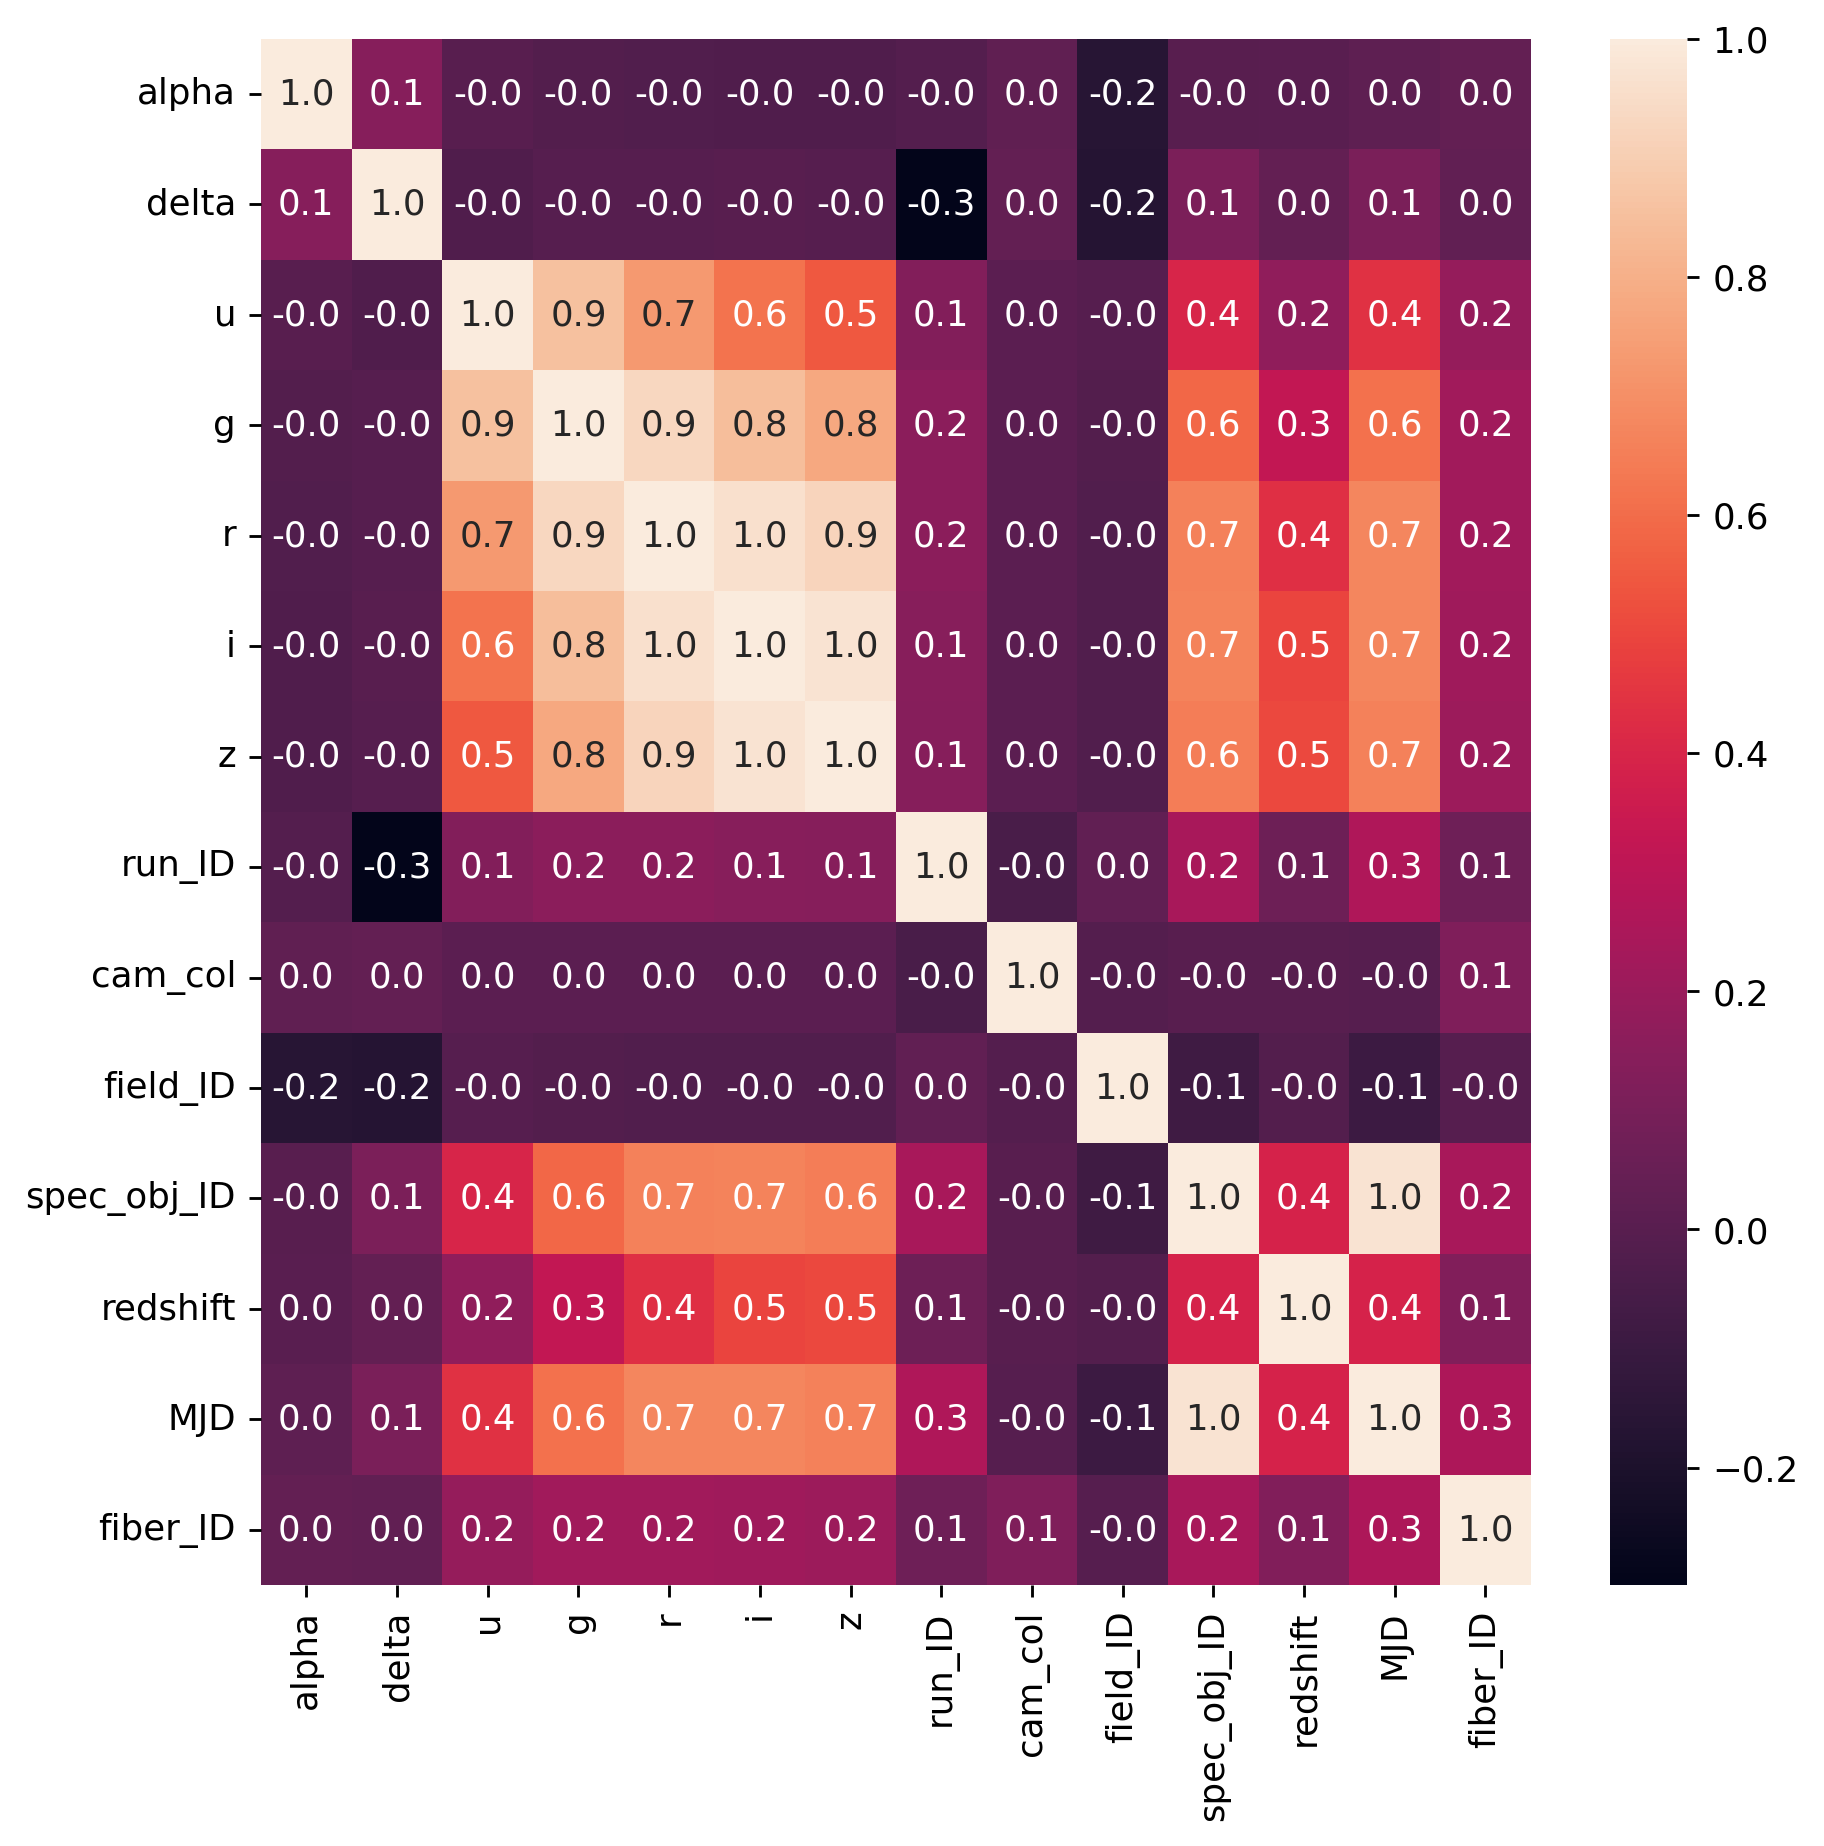

In [5]:
## jeszcze raz macierz korelacji -> widzimy, że usunęliśmy najbardziej skorelowane kolumny
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

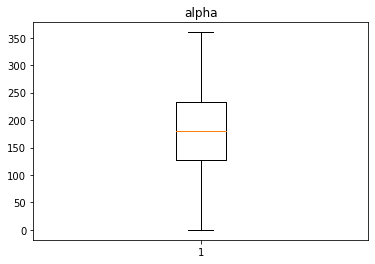

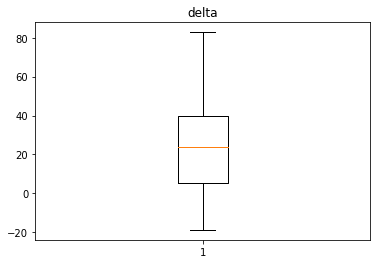

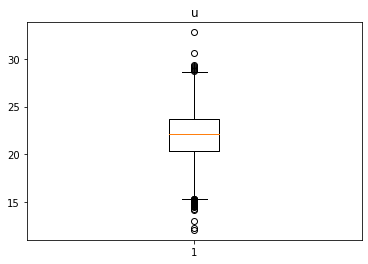

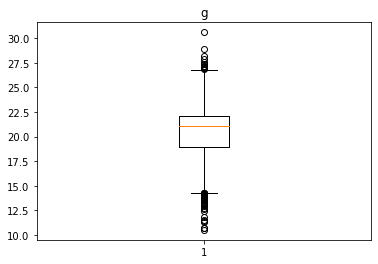

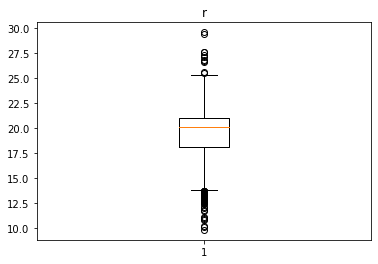

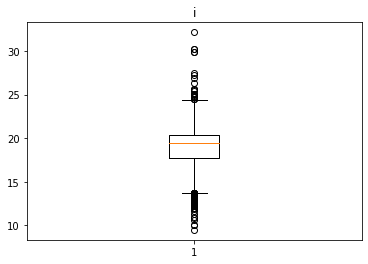

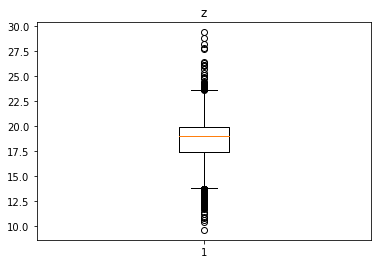

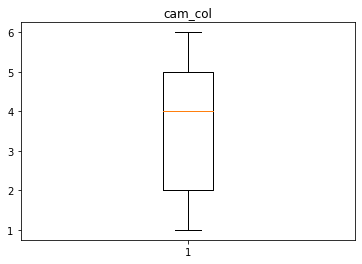

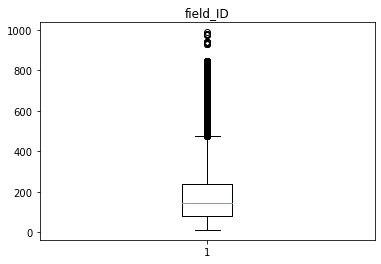

In [6]:
## usuwanie OUTLIERS: zobaczmy, dla których zmiennych wystąpują wartości odstające
for i in range(10):
    if i != 7:
        plt.boxplot(df.iloc[:, i])
        plt.title(df.columns[i])
        plt.show()

In [7]:
### przyjrzyjmy się outlierom w kolumnach 'u', 'r' jeszcze raz:
columns_to_be_checked = ['r', 'u']

for i in range(len(columns_to_be_checked)):
    column = df[columns_to_be_checked[i]]
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)

    IQR = Q3 - Q1

    outliers = (column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR))

    outliers_count = outliers.sum()

    outliers_percentage = outliers.mean() * 100
    df = df[~outliers]
    print(outliers_count)
    print("Ilość outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_count)
    print("Procentowy udział outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_percentage)
    
    ## usuńmy outliery dla u i r: stanowią tylko 0.13% i 0.03% wszystkich wierszy

92
Ilość outlierów dla kolumny  r :  92
Procentowy udział outlierów dla kolumny  r :  0.13142857142857142
16
Ilość outlierów dla kolumny  u :  16
Procentowy udział outlierów dla kolumny  u :  0.02288722320764433


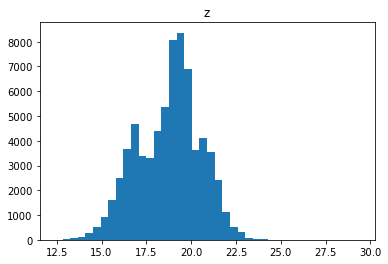

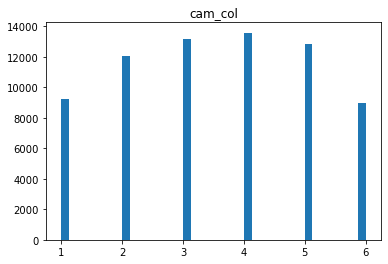

In [8]:
### spójrzmy jeszcze na dwie pozostałe kolumny z outlierami:

plt.hist(df.iloc[:, 6], bins = 40)
plt.title(df.columns[6])
plt.show()

plt.hist(df.iloc[:, 8], bins = 40)
plt.title(df.columns[8])
plt.show()

# zmienne redshift oraz filed_ID mają rozkład wykładniczy -> chyba nie usuwamy outlierów ???

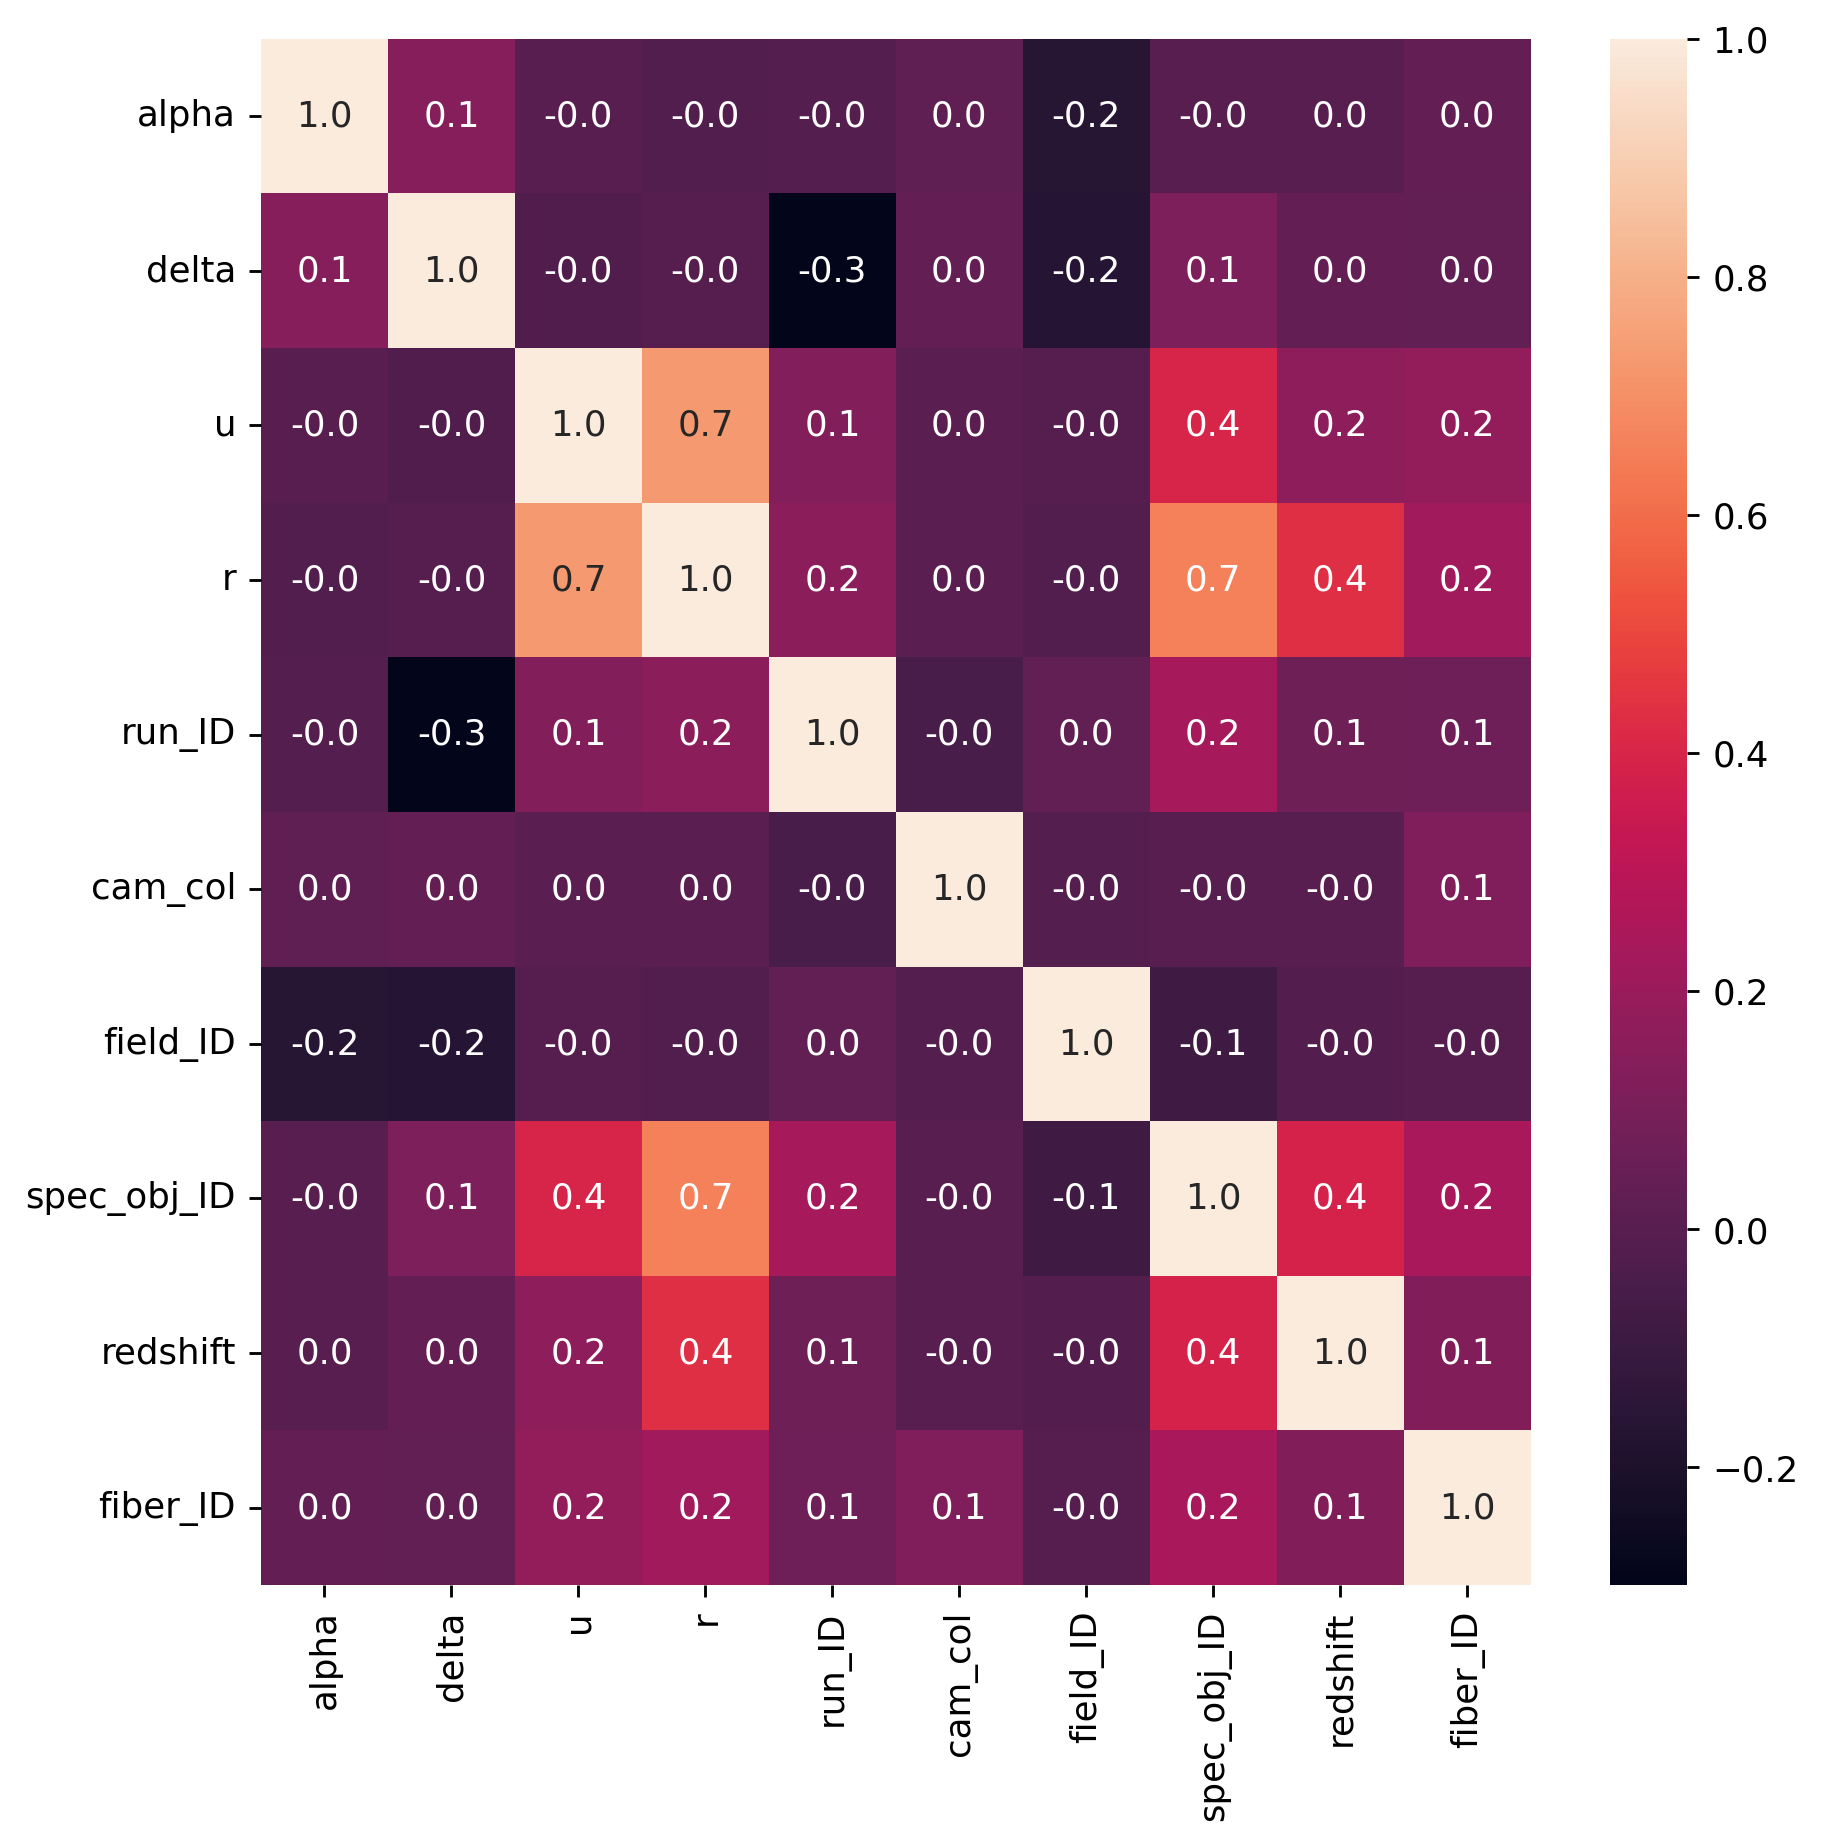

In [9]:
df = df.drop(['i', 'g', 'z', 'MJD'], axis = 1)
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

In [10]:
# Tworzenie kopii ramki danych
# df = development_unit_df.copy()

# Usuwanie kolumn
# df = df.drop(['i', 'g', 'z', 'MJD'], axis = 1)

# Korekta outlierów

# Zrównoważenie
y = df['class']
df = df.drop('class', axis=1)
smote = SMOTE()
df, y_resampled = smote.fit_resample(df, y)
df['class'] = pd.DataFrame(y_resampled)

# Zmiana zmiennej kategorycznej na numeryczną metodą one-hot
# df = pd.get_dummies(df, columns=['class'], prefix='', prefix_sep='', dtype=float)

# Normalizacja
columns_to_standardize = ['run_ID', 'fiber_ID', 'alpha', 'delta', 'redshift', 'spec_obj_ID', 'cam_col', 'u', 'r', 'field_ID']
df[columns_to_standardize] = MinMaxScaler().fit_transform(df[columns_to_standardize])

# Standaryzacja
columns_to_normalize = ['u']
df[columns_to_normalize] = StandardScaler().fit_transform(df[columns_to_normalize])

# Informacje o ramce danych
df.describe()

,alpha,delta,u,r,run_ID,cam_col,field_ID,spec_obj_ID,redshift,fiber_ID
count,124593.000000,124593.000000,1.245930e+05,124593.000000,124593.000000,124593.000000,124593.000000,124593.000000,124593.000000,124593.000000
mean,0.493248,0.427867,-5.623373e-16,0.514524,0.540480,0.480733,0.174420,0.415070,0.103170,0.449165
std,0.269710,0.195216,1.000004e+00,0.152048,0.242227,0.305364,0.143167,0.244705,0.125634,0.260849
min,0.000000,0.000000,-3.106643e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.348547,0.239002,-7.026556e-01,0.407814,0.381845,0.200000,0.074642,0.200557,0.001429,0.235235
50%,0.502103,0.432021,-1.303934e-02,0.554133,0.499814,0.400000,0.138037,0.399481,0.063443,0.431431
75%,0.654072,0.589349,6.655137e-01,0.628923,0.659630,0.800000,0.228016,0.605158,0.173205,0.636637
max,1.000000,1.000000,3.322023e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Testowanie

In [11]:
# test_models(df)

Wnioski
- przy zamianie outlierow z kolumn field_ID, redshift lub ich usunięciu, dokładności przykładowych 
modeli spadają do około 40 - 50 %
- normalizacja przed standaryzacją daje gorsze wyniki, bez standaryzacji zmiennej u też są gorsze wyniki
- można się jeszcze zastanowić nad usunięciem zmiennej 'r' ponieważ ma ona korelację z zmienną 'u' równą 0.73 
(co jest dosyć sporo) + bez tej zmiennej model ma porównywalną precyzyjność

### Druga iteracja

Inżynieria cech

In [12]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Usuwanie kolumn
df = df.drop(['i', 'g', 'z', 'spec_obj_ID'], axis = 1)

# Korekta outlierów

# Zrównoważenie

# Zmiana zmiennej kategorycznej na numeryczną metodą one-hot
# df = pd.get_dummies(df, columns=['class'], prefix='', prefix_sep='', dtype=float)

# Normalizacja
columns_to_standardize = ['run_ID', 'fiber_ID', 'alpha', 'delta', 'redshift', 'MJD', 'cam_col', 'u', 'r', 'field_ID']
df[columns_to_standardize] = MinMaxScaler().fit_transform(df[columns_to_standardize])

# Standaryzacja

# Informacje o ramce danych
df.describe()

,alpha,delta,u,r,run_ID,cam_col,field_ID,redshift,MJD,fiber_ID
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,0.493114,0.422723,0.482648,0.497355,0.542195,0.501829,0.178182,0.083607,0.542924,0.448349
std,0.267455,0.193547,0.108944,0.093949,0.243685,0.317937,0.151595,0.104186,0.247111,0.272808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.354708,0.236441,0.398973,0.420672,0.381845,0.200000,0.072597,0.009132,0.358411,0.220220
50%,0.501623,0.417931,0.487227,0.521688,0.506519,0.600000,0.138037,0.061675,0.581376,0.431431
75%,0.649092,0.578041,0.560491,0.568067,0.647833,0.800000,0.233129,0.101793,0.705625,0.643644
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Testowanie

In [13]:
test_models(df)

Dokładności modeli:
LogisticRegression 0.9286428571428571
KNeighborsClassifier: 0.8553571428571428
RandomForestClassifier: 0.9736428571428571
DecisionTreeClassifier: 0.9565


Wnioski